In [1]:
from pathlib import Path

import numpy as np
import torch

from tqdm.auto import tqdm

import itertools

import os
from dotenv import find_dotenv, load_dotenv

load_dotenv(find_dotenv(), verbose=True)

True

# prepare data

In [2]:
from src.config.config import combine_cfgs, get_cfg_defaults
from src.data.datamodule import MyDataModule

In [3]:
# prepare videos
cfg = combine_cfgs('../src/config/experiments/algonauts2021_i3d_rgb.yml')
dm = MyDataModule(cfg)
dm.prepare_data()
dm.setup()

prepare data:   0%|          | 0/1102 [00:00<?, ?it/s]

prepare data:   0%|          | 0/1102 [00:00<?, ?it/s]

In [6]:
video_dir = Path.joinpath(dm.dataset_train_val.raw_dir, 'AlgonautsVideos268_All_30fpsmax')
video_paths = sorted(list(video_dir.glob('*.mp4')))

# detector

In [9]:
def read_video_to_numpy(path):
    cap = cv2.VideoCapture(path)
    ret = True
    frames = []
    while ret:
        ret, img = cap.read() # read one frame from the 'capture' object; img is (H, W, C)
        if ret:
            img = cv2.resize(img, dsize=(300, 300))
            frames.append(img)
    video = np.stack(frames, axis=0) # dimensions (T, H, W, C)
    return video

In [10]:
def decode_detections(detections, confidence=0.90):
    column_labels = ["img_id", "is_face", "confidence", "left", "top", "right", "bottom"]
    detections_df = pd.DataFrame(detections[0][0], columns = column_labels)
    length = len(detections_df)
    chunk = 200
    
    face_counts = []
    i = 1
    while i*chunk <= length:
        img_df = detections_df[(i-1)*chunk:i*chunk]
        img_df = img_df[img_df['is_face'] == 1]
        img_df = img_df[img_df['confidence'] >= confidence]
        face_count = len(img_df)
        face_counts.append(face_count)
        i += 1
    
    return face_counts

In [18]:
import functools
import os
import pathlib
import pickle
import re
import subprocess

def which_ffmpeg() -> str:
    '''Determines the path to ffmpeg library

    Returns:
        str -- path to the library
    '''
    result = subprocess.run(['which', 'ffmpeg'], stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
    ffmpeg_path = result.stdout.decode('utf-8').replace('\n', '')
    return ffmpeg_path


def reencode_video_with_diff_fps(video_path: str, tmp_path: str, extraction_fps: int) -> str:
    '''Reencodes the video given the path and saves it to the tmp_path folder.

    Args:
        video_path (str): original video
        tmp_path (str): the folder where tmp files are stored (will be appended with a proper filename).
        extraction_fps (int): target fps value

    Returns:
        str: The path where the tmp file is stored. To be used to load the video from
    '''
    assert which_ffmpeg() != '', 'Is ffmpeg installed? Check if the conda environment is activated.'
    assert video_path.endswith('.mp4'), 'The file does not end with .mp4. Comment this if expected'
    # create tmp dir if doesn't exist
    os.makedirs(tmp_path, exist_ok=True)

    # form the path to tmp directory
    new_path = os.path.join(tmp_path, f'{pathlib.Path(video_path).stem}_new_fps.mp4')
    cmd = f'{which_ffmpeg()} -hide_banner -loglevel panic '
    cmd += f'-y -i {video_path} -t 2.9493087557603688 -filter:v fps=fps={extraction_fps} {new_path}'
    # cmd += f'-y -i {video_path} -t 2.9493087557603688 -filter:v minterpolate {new_path}'
    subprocess.call(cmd.split())
    return new_path

In [19]:
import cv2
detector = cv2.dnn.readNetFromCaffe("./tmp/deploy.prototxt" , "./tmp/res10_300x300_ssd_iter_140000.caffemodel")
# https://github.com/gopinath-balu/computer_vision/tree/master/CAFFE_DNN

In [21]:
all_detections = []
for video_path in tqdm(video_paths):
    video_path = str(video_path)
    tmp_path = reencode_video_with_diff_fps(video_path, '/tmp/', extraction_fps=5.5)
    video = read_video_to_numpy(tmp_path)
    video = np.moveaxis(video, -1, 1)
    detector.setInput(video)
    detections = detector.forward()
    all_detections.append(detections)

  0%|          | 0/1102 [00:00<?, ?it/s]

In [23]:
import pandas as pd

In [32]:
confidence = 0.95
all_face_counts = []
for detections in tqdm(all_detections):
    face_counts = decode_detections(detections, confidence=confidence)
    all_face_counts.append(face_counts)
all_face_counts = np.stack(all_face_counts)

  0%|          | 0/1102 [00:00<?, ?it/s]

In [33]:
yes_face_vid_idxs = all_face_counts.max(-1).nonzero()[0]

In [34]:
print(len(yes_face_vid_idxs))

173


In [35]:
import matplotlib.pyplot as plt

  0%|          | 0/173 [00:00<?, ?it/s]

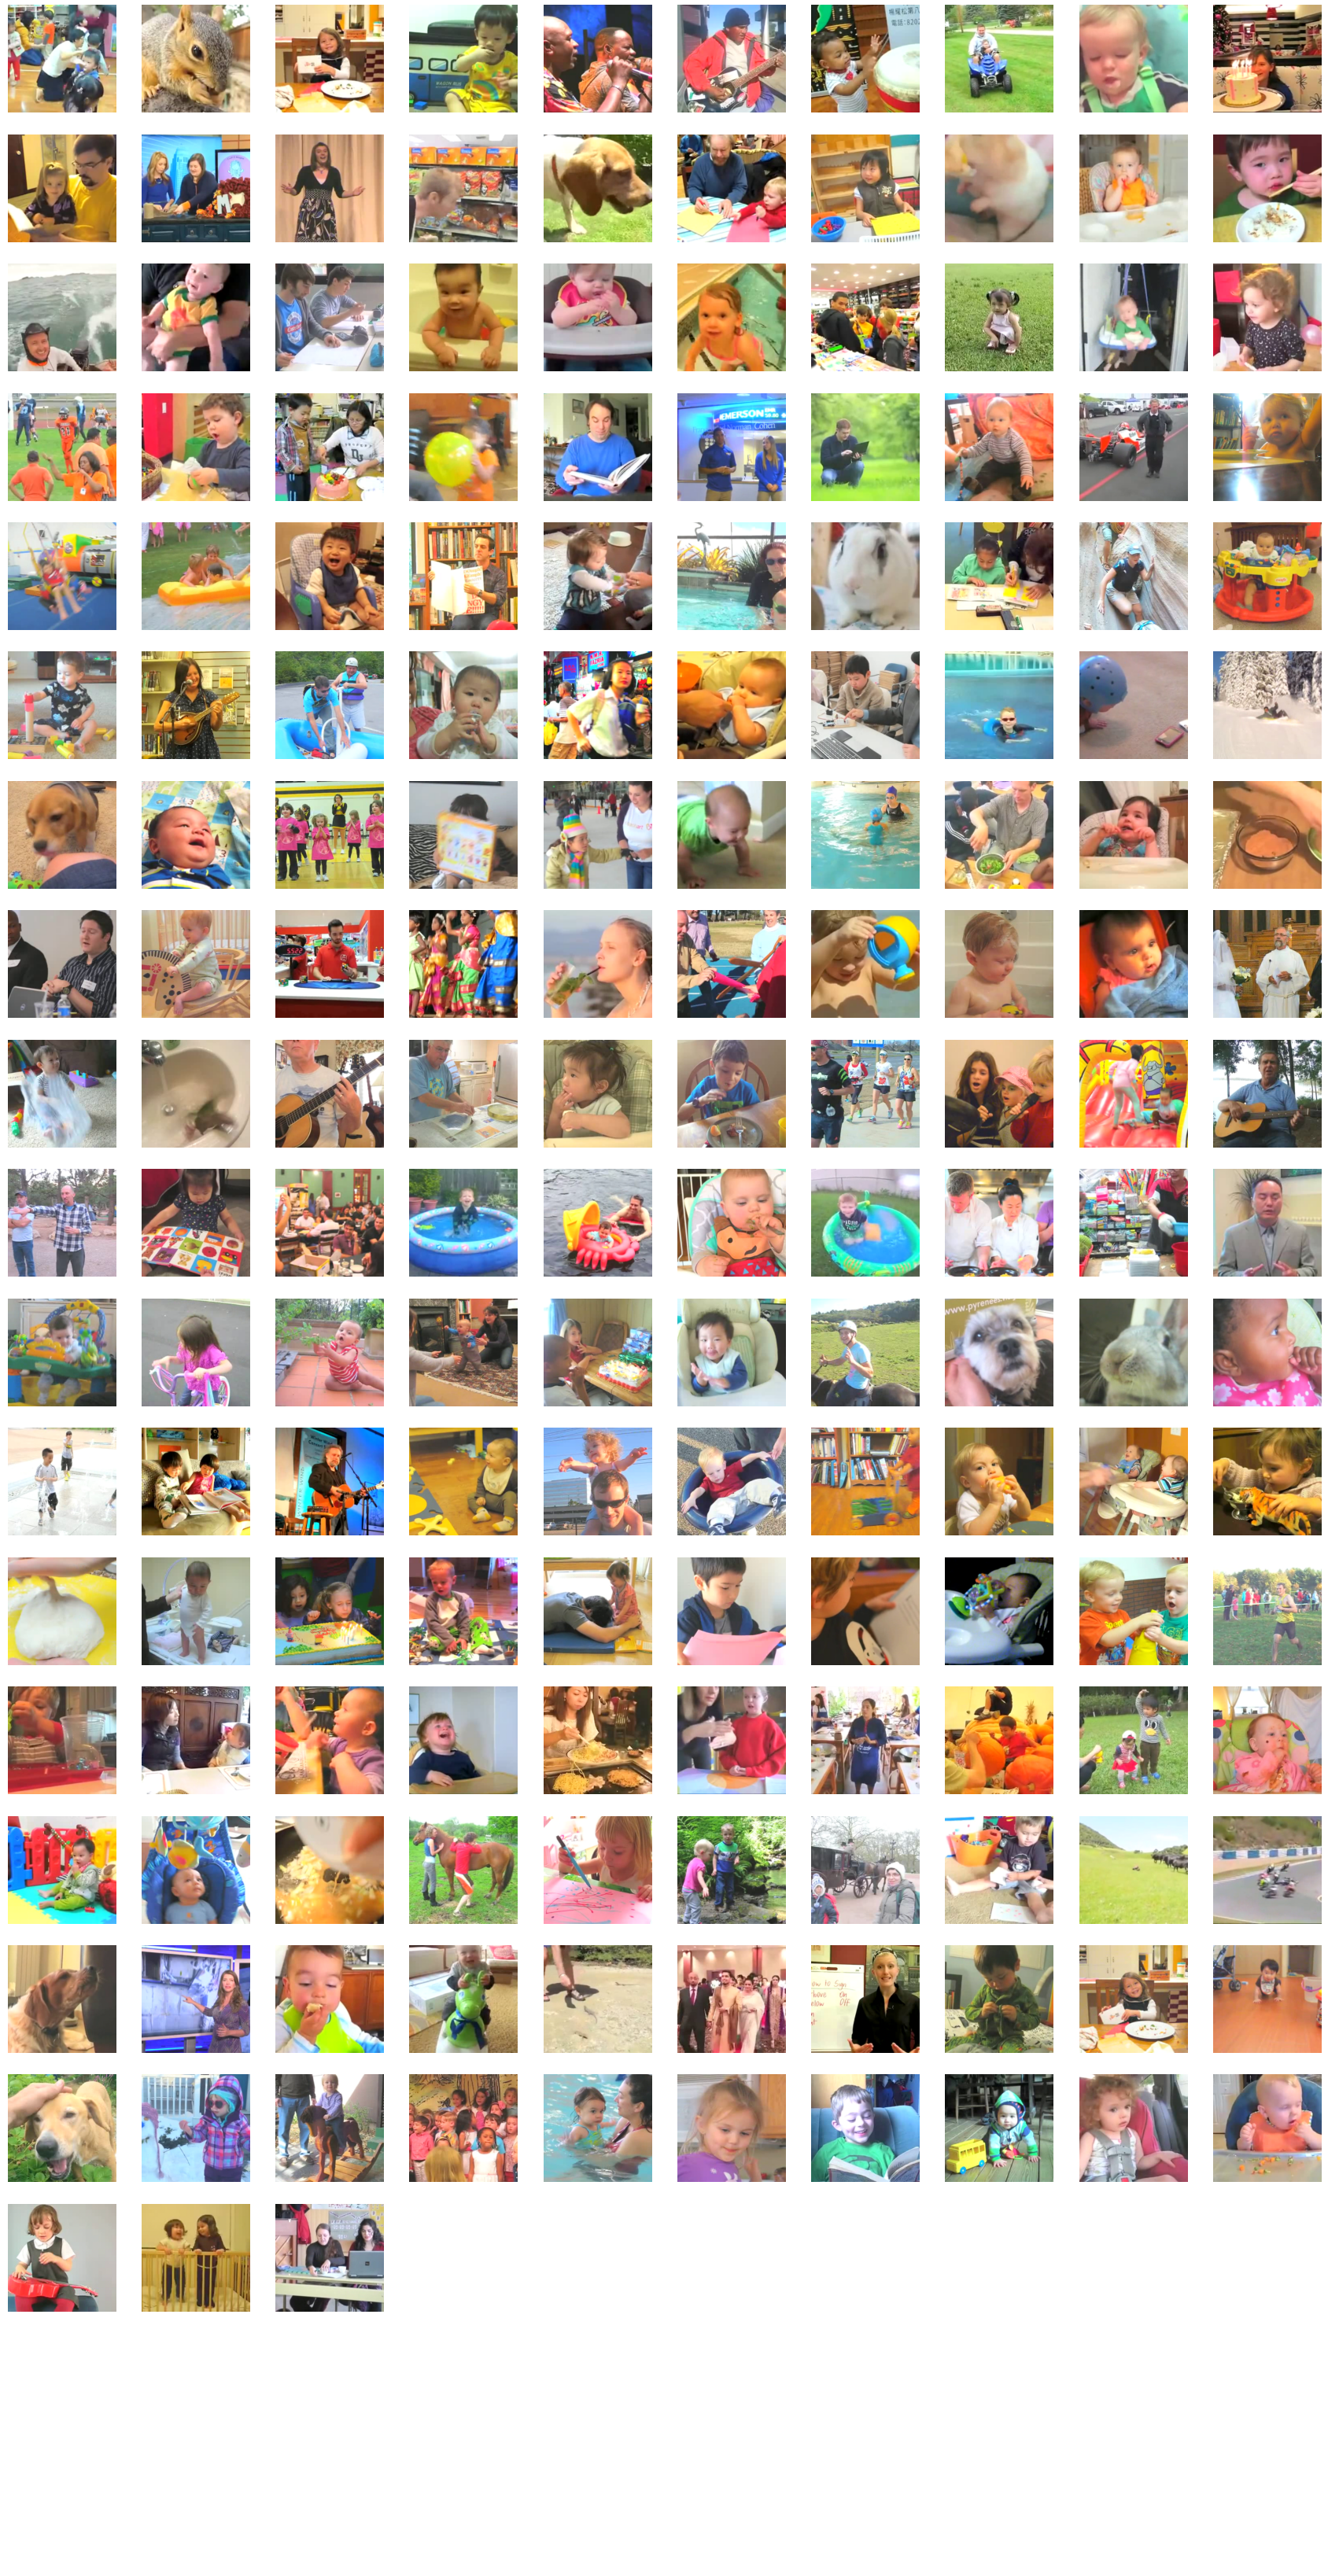

In [36]:
nrows = 20
ncols = 10
num_axs = nrows * ncols
size = 3

fig, axs = plt.subplots(nrows, ncols,
                      figsize=(ncols*size, nrows*size))
axes = axs.flatten()
for ax in axes:
    ax.axis('off')

ii = 0
for i in tqdm(yes_face_vid_idxs):
    i_frame = all_face_counts[i].argmax()
    video_path = video_paths[i]
    video_path = str(video_path)
    tmp_path = reencode_video_with_diff_fps(video_path, '/tmp/', extraction_fps=5.5)
    video = read_video_to_numpy(tmp_path)
    img = video[i_frame]
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[ii].imshow(img)
    axes[ii
    ii += 1
    if ii >= num_axs:
        break
plt.show()

In [37]:
np.save('./tmp/face_counts.npy', all_face_counts)